In [1]:
import os
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
from models.winnet.splitmerge import DCTSplitMerge            # your module

In [2]:
IMAGES_FOLDER = 'C:\\Users\\leeji\\fyp\\pytorch_code\\report_figures'
IMAGES_FOLDER

'C:\\Users\\leeji\\fyp\\pytorch_code\\report_figures'

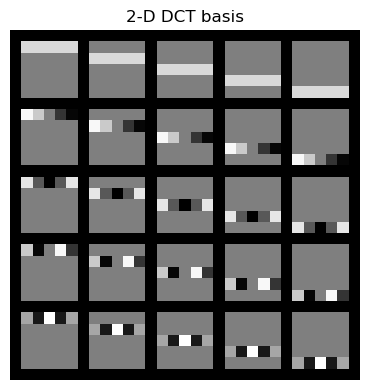

In [3]:
# ----- 1. visualise the filters ------------------------------------------------
dct = DCTSplitMerge(patch_size=5, out_channels=25)   # 8×8 DCT, keep 64 comps
filters = dct.analysis_filters.cpu()                # (1, 64, 8, 8)
grid = make_grid(filters, nrow=5, normalize=True, padding=1)
plt.figure(figsize=(4, 4)); plt.title("2-D DCT basis")
plt.imshow(grid.permute(1,2,0))
plt.axis("off")

plt.tight_layout()
plt.savefig(f"{IMAGES_FOLDER}\\2d_dct_basis.png", bbox_inches='tight')
plt.show()

In [4]:
def min_max_normalize(x):
    x = x - x.min()
    x = x / x.max()
    return x

In [5]:
# ----- 2. coarse / detail decomposition on a sample image ----------------------
to_tensor = T.Compose([T.Resize(256), T.ToTensor()])
img = to_tensor(Image.open("pickup.jpg").convert("L")).unsqueeze(0)  # (1,1,H,W)

x_c, x_d = dct(img)                         # split
x_c_rec = dct.inverse(x_c, torch.zeros_like(x_d))   # coarse-only reconstruction
x_d_rec = dct.inverse(torch.zeros_like(x_c), x_d)   # detail-only reconstruction
x_rec    = dct.inverse(x_c, x_d)                    # full reconstruction

# fig, axs = plt.subplots(1, 4, figsize=(9, 3))
# for ax, im, title in zip(axs,
#         [img, x_c_rec, x_d_rec, x_rec],
#         ["Original", "Coarse part", "Detail part", "Reconstructed"]):
#     ax.imshow(im.squeeze().cpu(), cmap="gray"); ax.set_title(title); ax.axis("off")


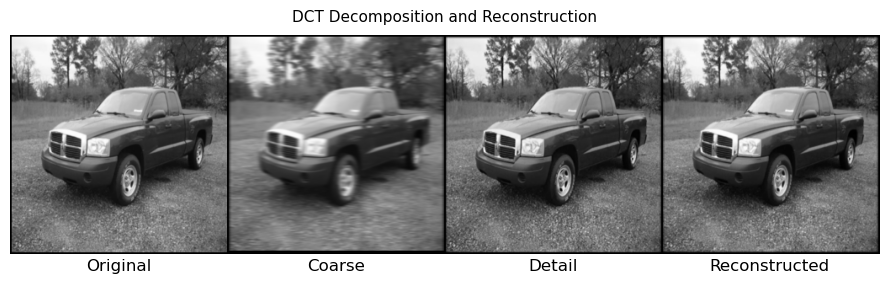

In [9]:
# stack images into a batch tensor
x_c_rec = min_max_normalize(x_c_rec)
x_d_rec = min_max_normalize(x_d_rec)
x_rec = min_max_normalize(x_rec)

images = torch.stack([
    img.squeeze() if img.dim() > 2 else img,
    x_c_rec.squeeze() if x_c_rec.dim() > 2 else x_c_rec,
    x_d_rec.squeeze() if x_d_rec.dim() > 2 else x_d_rec,
    x_rec.squeeze() if x_rec.dim() > 2 else x_rec
])

# if images are single channel, add channel dimension
if images.dim() == 3:
    images = images.unsqueeze(1)

# create grid with minimal padding
grid = make_grid(images, nrow=4, padding=2, normalize=False)

plt.figure(figsize=(9,3))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu(), cmap="gray")
plt.axis("off")

titles = ["Original", "Coarse", "Detail", "Reconstructed"]
img_width = grid.shape[2] // 4
for i, title in enumerate(titles):
    x_pos = (i + 0.5) * img_width / grid.shape[2]
    plt.text(x_pos, -0.02, title, transform=plt.gca().transAxes, 
             ha='center', va='top', fontsize=12)

plt.suptitle("DCT Decomposition and Reconstruction", fontsize=11, y=0.9)
plt.tight_layout()
plt.savefig(f"{IMAGES_FOLDER}\\dct_coarse_detail_recon.png", bbox_inches='tight')
plt.show()

In [10]:
import torch, matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
from models.winnet.splitmerge import MultiScaleStationaryHaar   # your module

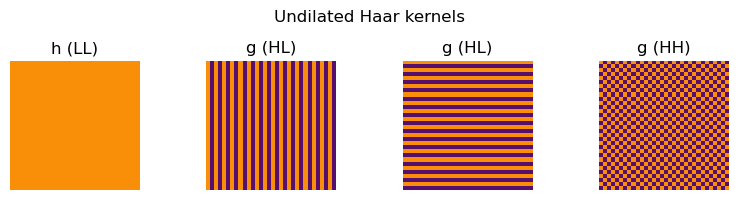

In [22]:
# ----- parameters ------------------------------------------------------------
wave = MultiScaleStationaryHaar(num_scales=3, in_channels=1)  # 3-level SWT
img = to_tensor(Image.open("pickup.jpg").convert("L")).unsqueeze(0)  # (1,1,H,W)
if isinstance(img, torch.Tensor):
    x = img.clone().detach().float() / 255.
else:
    x = torch.tensor(img, dtype=torch.float32) / 255.

# ----- 1. visualise (dilated) filters ----------------------------------------
fig, axs = plt.subplots(1,4, figsize=(8,2))
titles   = [r"h (LL)", r"g (HL)", r"g (HL)", r"g (HH)"]
for k in range(4):
    f = wave.base_filters[k,0]          # (2,2)
    f = torch.kron(torch.ones((16,16)), f)  # upsample for viewing
    axs[k].imshow(f, cmap="inferno", vmin=-0.5, vmax=0.5)
    axs[k].set_title(titles[k]); axs[k].axis("off")
    
plt.suptitle("Undilated Haar kernels", y=0.98)
plt.tight_layout()
plt.savefig(f"{IMAGES_FOLDER}\\undliated_haar_kernels.png", bbox_inches='tight')

In [20]:
x.shape

torch.Size([1, 1, 256, 256])

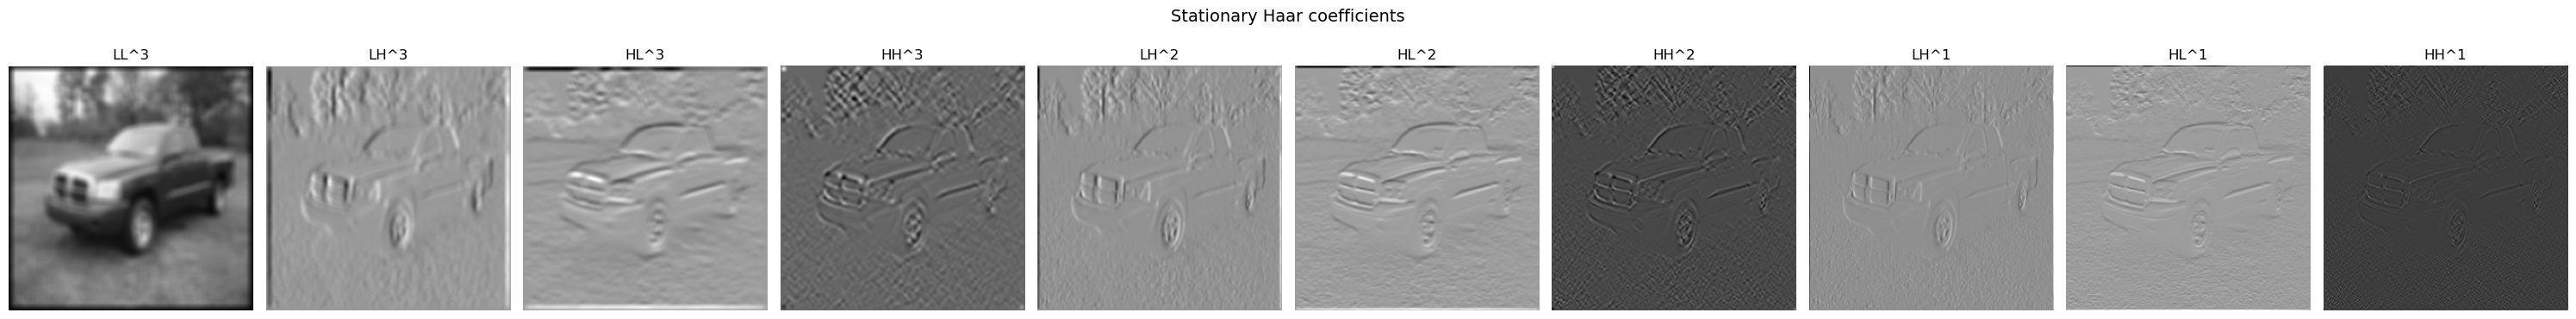

In [24]:
# ----- 2. multi-scale decomposition ------------------------------------------
x_c, x_d = wave(x)                      # split
bands = [x_c] + list(torch.split(x_d, 3, dim=1))  # LL^3, (LH,HL,HH)^3 ...

# Collect all images and titles
all_images = []
all_titles = []

for j, band in enumerate(bands):
    if j == 0:  # coarse only
        all_images.append(band.squeeze())
        all_titles.append("LL^3")
    else:
        for k in range(3):
            all_images.append(band[:,k].squeeze())
            all_titles.append(["LH","HL","HH"][k] + f"^{4-j}")

# Create single row subplot
n_images = len(all_images)
fig, axs = plt.subplots(1, n_images, figsize=(3*n_images, 4))

# Plot each image
for i, (img, title) in enumerate(zip(all_images, all_titles)):
    axs[i].imshow(img.cpu(), cmap="gray")
    axs[i].set_title(title)
    axs[i].axis("off")

plt.suptitle("Stationary Haar coefficients", fontsize=14, y=0.98)
plt.tight_layout()
plt.savefig(f"{IMAGES_FOLDER}\\stationary_haar_decomp.png", bbox_inches='tight')
plt.show()

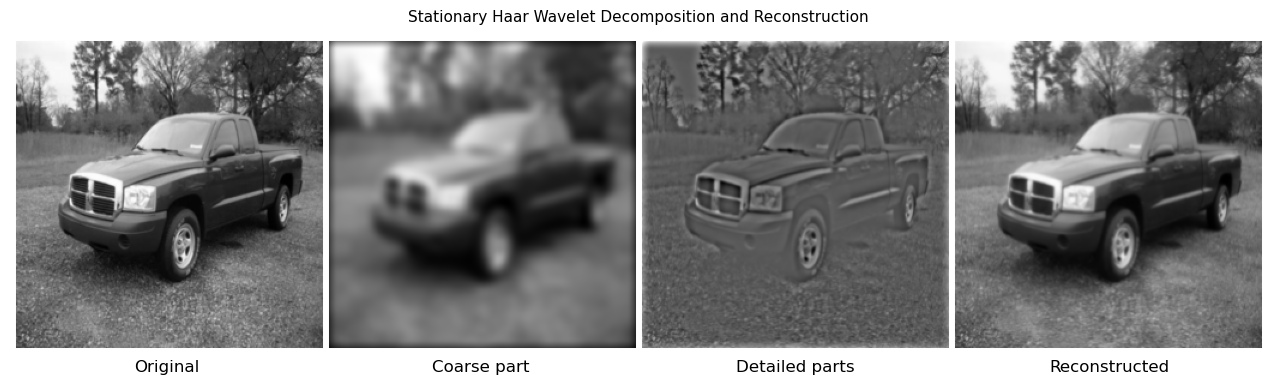

In [28]:
# ----- Simple reconstruction visualization ---------------------------------
wave = MultiScaleStationaryHaar(num_scales=3, in_channels=1)  # 3-level SWT
img = to_tensor(Image.open("pickup.jpg").convert("L")).unsqueeze(0)  # (1,1,H,W)
if isinstance(img, torch.Tensor):
    x = img.clone().detach().float() / 255.
else:
    x = torch.tensor(img, dtype=torch.float32) / 255.
# 1. Original image
original = img.squeeze().cpu()

# 2. Coarse part (LL^3) - reconstruct with only coarse approximation
zero_details = torch.zeros_like(x_d)
coarse_rec = wave.inverse(x_c, zero_details).squeeze().cpu()

# 3. Sum of detailed parts - reconstruct with only details (no coarse)
zero_coarse = torch.zeros_like(x_c)
details_rec = wave.inverse(zero_coarse, x_d).squeeze().cpu()

# 4. Final reconstruction - combine coarse and all details
final_rec = wave.inverse(x_c, x_d).squeeze().cpu()

# Collect all images and titles
images = [original, coarse_rec, details_rec, final_rec]
for idx, image in enumerate(images):
    images[idx] = min_max_normalize(image)
    
titles = ["Original", "Coarse part", "Detailed parts", "Reconstructed"]

# Stack images into a tensor for make_grid
images_tensor = torch.stack(images)

# Add channel dimension if needed
if images_tensor.dim() == 3:
    images_tensor = images_tensor.unsqueeze(1)

# Create grid with 4 images in one row
grid = make_grid(images_tensor, nrow=4, padding=5, normalize=False, pad_value=1)

# Plot
plt.figure(figsize=(16, 4))
plt.imshow(grid.permute(1, 2, 0).squeeze().cpu(), cmap="gray")
plt.axis("off")

# Add titles manually
img_width = grid.shape[2] // 4  # Width of each image in the grid
for i, title in enumerate(titles):
    x_pos = (i + 0.5) * img_width / grid.shape[2]  # Relative position
    plt.text(x_pos, -0.02, title, transform=plt.gca().transAxes, 
             ha='center', va='top', fontsize=12)

plt.suptitle("Stationary Haar Wavelet Decomposition and Reconstruction", fontsize=11, y=0.95) # y=0.98
plt.tight_layout()

plt.savefig(f"{IMAGES_FOLDER}\\stationary_haar_recon.png", bbox_inches='tight')
plt.show()

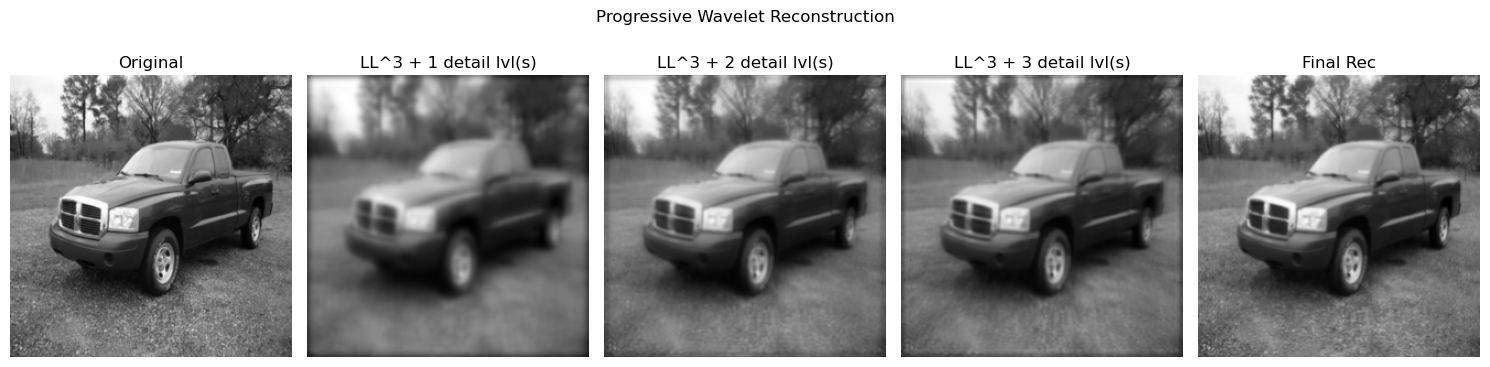

In [30]:
# ----- 3. progressive reconstruction -----------------------------------------
rec = []
img = to_tensor(Image.open("pickup.jpg").convert("L")).unsqueeze(0)  # (1,1,H,W)
if isinstance(img, torch.Tensor):
    x = img.clone().detach().float() / 255.
else:
    x = torch.tensor(img, dtype=torch.float32) / 255.
x_c, x_d = wave(x) 
bands = [x_c] + list(torch.split(x_d, 3, dim=1))  # LL^3, (LH,HL,HH)^3 ...
current_c = x_c.clone()

# Progressive reconstruction by adding details level by level cumulatively
for level in range(1, wave.num_scales + 1):
    # Create detail tensor with details from level 1 up to current level
    cumulative_details = torch.zeros_like(x_d)
    
    for j in range(1, level + 1):
        # Get details for scale j
        detail_j = bands[-j]  # (LH,HL,HH) at scale j
        
        # Calculate the starting index for this scale's details in x_d
        start_idx = (j - 1) * 3
        end_idx = j * 3
        cumulative_details[:, start_idx:end_idx] = detail_j
    
    # Reconstruct with coarse + cumulative details up to current level
    rec_img = wave.inverse(x_c, cumulative_details)
    rec.append(rec_img.squeeze().cpu())

# Combine all images: original + progressive reconstructions
final_rec = wave.inverse(x_c, x_d).squeeze().cpu()
all_images = [img.squeeze().cpu()] + rec + [final_rec]
all_titles = ["Original"] + [f"LL^3 + {i} detail lvl(s)" for i in range(1, len(rec) + 1)] + ["Final Rec"]

# Plot all in single row
fig = plt.figure(figsize=(3 * len(all_images), 4))
for i, (image, title) in enumerate(zip(all_images, all_titles)):
    ax = fig.add_subplot(1, len(all_images), i+1)
    ax.imshow(image, cmap="gray")
    ax.set_title(title)
    ax.axis("off")

plt.suptitle("Progressive Wavelet Reconstruction")
plt.tight_layout()
plt.show()

## Decimated Haar Wavelet Transform

In [31]:
import torch, matplotlib.pyplot as plt
from PIL import Image
from models.winnet.splitmerge import HaarSplitMerge               # your class

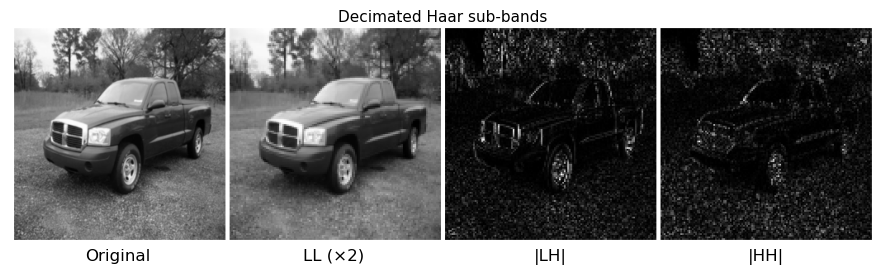

In [36]:
# ------------------------------------------------------------------ parameters
wave = HaarSplitMerge()
img = to_tensor(Image.open("pickup.jpg").convert("L")).unsqueeze(0)  # (1,1,H,W)
if isinstance(img, torch.Tensor):
    x = img.clone().detach().float() / 255.
else:
    x = torch.tensor(img, dtype=torch.float32) / 255.

# ---------------------------------------------------------------- decomposition
x_c, x_d = wave(x)                      # LL, detail (LH|HL|HH)
lh, hl, hh = torch.chunk(x_d, 3, dim=1)

# ---------------------------------------------------------------- visual helper
def up(img_coeff):                      # nearest-neighbour 2× upsample for display
    return torch.nn.functional.interpolate(img_coeff, scale_factor=2, mode="nearest")

# ---------------------------------------------------------------- figure 1: sub-bands using make_grid
from torchvision.utils import make_grid

# Prepare sub-band images with normalization
subband_images = [
    min_max_normalize(x).squeeze(),
    min_max_normalize(up(x_c)).squeeze(),
    min_max_normalize(up(lh.abs())).squeeze(),
    min_max_normalize(up(hh.abs())).squeeze()
]
subband_titles = ["Original", "LL (×2)", "|LH|", "|HH|"]

# Stack images for make_grid - ensure all have same shape
subband_tensor = torch.stack(subband_images)
if subband_tensor.dim() == 3:
    subband_tensor = subband_tensor.unsqueeze(1)

# Create grid
subband_grid = make_grid(subband_tensor, nrow=4, padding=5, normalize=False, pad_value=1)

# Plot sub-bands
plt.figure(figsize=(12, 3))
plt.imshow(subband_grid.permute(1, 2, 0).squeeze().cpu(), cmap="gray")
plt.axis("off")

# Add titles
img_width = subband_grid.shape[2] // 4
for i, title in enumerate(subband_titles):
    x_pos = (i + 0.5) * img_width / subband_grid.shape[2]
    plt.text(x_pos, -0.02, title, transform=plt.gca().transAxes, 
             ha='center', va='top', fontsize=12)

plt.suptitle("Decimated Haar sub-bands", fontsize=11, y=0.9)
plt.tight_layout()
plt.savefig(f"{IMAGES_FOLDER}\\decimated_haar_decomp.png", bbox_inches='tight')
plt.show()

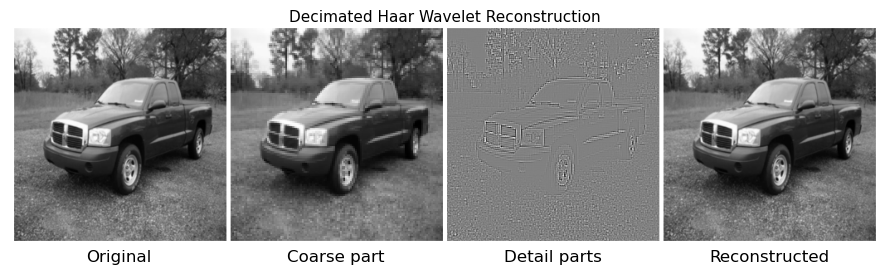

In [35]:
# ---------------------------------------------------------------- figure 2: reconstruction using make_grid
x_rec = wave.inverse(x_c, x_d)

# Create aggregated detail parts (sum of LH, HL, HH)
zero_coarse = torch.zeros_like(x_c)
details_rec = wave.inverse(zero_coarse, x_d)

# Create coarse part reconstruction
zero_details = torch.zeros_like(x_d)
coarse_rec = wave.inverse(x_c, zero_details)

# Prepare reconstruction images with normalization
recon_images = [
    min_max_normalize(x).squeeze(),
    min_max_normalize(coarse_rec).squeeze(),
    min_max_normalize(details_rec).squeeze(),
    min_max_normalize(x_rec).squeeze()
]
recon_titles = ["Original", "Coarse part", "Detail parts", "Reconstructed"]

# Stack images for make_grid - ensure all have same shape
recon_tensor = torch.stack(recon_images)
if recon_tensor.dim() == 3:
    recon_tensor = recon_tensor.unsqueeze(1)

# Create grid
recon_grid = make_grid(recon_tensor, nrow=4, padding=5, normalize=False, pad_value=1)

# Plot reconstruction
plt.figure(figsize=(12, 3))
plt.imshow(recon_grid.permute(1, 2, 0).squeeze().cpu(), cmap="gray")
plt.axis("off")

# Add titles
img_width = recon_grid.shape[2] // 4
for i, title in enumerate(recon_titles):
    x_pos = (i + 0.5) * img_width / recon_grid.shape[2]
    plt.text(x_pos, -0.02, title, transform=plt.gca().transAxes, 
             ha='center', va='top', fontsize=12)

plt.suptitle("Decimated Haar Wavelet Reconstruction", fontsize=11, y=0.9)
plt.tight_layout()
plt.savefig(f"{IMAGES_FOLDER}\\decimated_haar_recon.png", bbox_inches='tight')
plt.show()